# ZNF462
[Weiss-Kruszka syndrome (WSKA)](https://omim.org/entry/618619) is caused by heterozygous mutation in the [ZNF462](https://omim.org/entry/617371) gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.0


### ZNF462
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZNF462.

In [2]:
gene_symbol = 'ZNF462'
mane_tx_id = 'NM_021224.6'
mane_protein_id = 'NP_067047.4' # zinc finger protein 462 isoform 1

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 39/39 [02:10<00:00,  3.33s/individuals]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #11
   errors:
   ·Individual PMID_39069253_individual_5_Ramocki_et_al has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_39069253_individual_5_Ramocki_et_al has an error with variant SO:1000044_HGNC:21684_ZNF462. Try again or remove variant from testing... Unsupported variant class VariantClass.TRANSLOCATION
  patient #19
   errors:
   ·Individual PMID_39069253_individual_29_Kruszka_et_al has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_39069253_individual_29_Kruszka_et_al has an error with variant SO:1000044_HGNC:21684_ZNF462. Try again or remove variant from testing... Unsupported variant class 

In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(phenopackets=phenopackets,cohort_creator=cohort_creator,)

Individuals Processed: 100%|██████████| 39/39 [00:50<00:00,  1.30s/individuals]


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Ptosis,HP:0000508,32
Global developmental delay,HP:0001263,29
Broad philtrum,HP:0000289,22
Highly arched eyebrow,HP:0002553,20
Downslanted palpebral fissures,HP:0000494,19
Exaggerated cupid's bow,HP:0002263,19
Delayed speech and language development,HP:0000750,18
Anteverted nares,HP:0000463,17
Bulbous nose,HP:0000414,17
Motor delay,HP:0001270,16


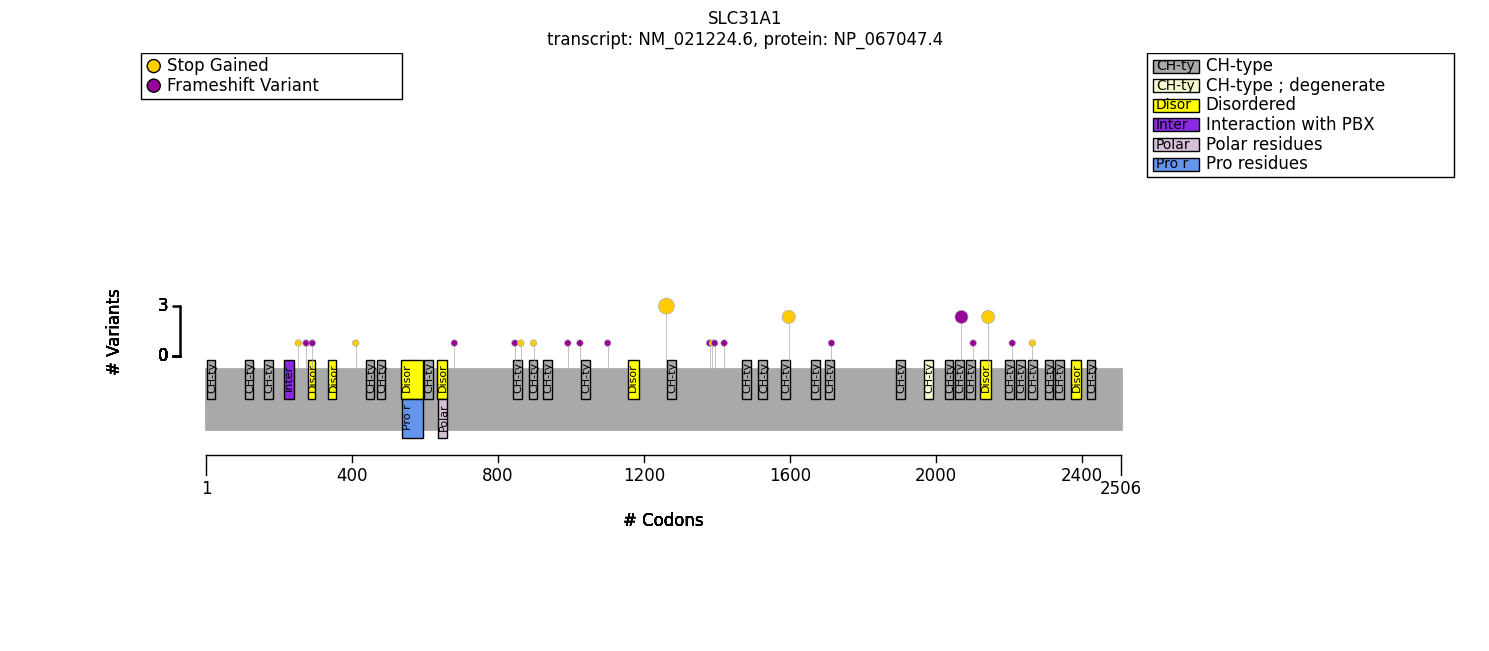

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="SLC31A1",
        uniprot_json="Q96JM2.json",
        protein_length=2506,
)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis
All published variants belong to categories that are often considered to be loss of function (FRAMESHIFT_VARIANT, TRANSCRIPT_ABLATION, STOP_GAINED, SPLICE_ACCEPTOR_VARIANT). We will test transcript ablation and the most commonly reported variant.

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.view import MtcStatsViewer

ablation = VariantPredicates.variant_effect(VariantEffect.TRANSCRIPT_ABLATION, mane_tx_id)
abl_pred = monoallelic_predicate(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="Ablation",
    b_label="Other"
)
abl_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=abl_pred,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(abl_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,19
HMF03,Skipping term because of a child term with the same individual counts,7
HMF05,Skipping term because one genotype had zero observations,5
HMF08,Skipping general term,42
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,61


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=abl_result)

Allele group                                       Ablation          Other  \
                                                      Count Percent  Count   
Hearing impairment [HP:0000365]                         3/5     60%   5/26   
Delayed speech and language development [HP:000...      0/4      0%  16/28   
Low-set ears [HP:0000369]                               2/4     50%   3/23   
Prominent metopic ridge [HP:0005487]                    0/4      0%  12/28   
Intellectual disability [HP:0001249]                    3/4     75%   9/26   
Feeding difficulties [HP:0011968]                       1/6     17%  10/25   
Broad philtrum [HP:0000289]                             5/7     71%  14/27   
Exaggerated cupid's bow [HP:0002263]                    3/4     75%  14/27   
Highly arched eyebrow [HP:0002553]                      2/5     40%  15/28   
Neurodevelopmental abnormality [HP:0012759]             6/6    100%  22/22   
Abnormal eyebrow morphology [HP:0000534]                2/2    100%  15/15   
Abnormal ocular adnexa morphology [HP:0030669]          3/3    100%  21/21   
Neurodevelopmental delay [HP:0012758]                   6/6    100%  21/21   
Motor delay [HP:0001270]                                2/4     50%  12/28   
Global developmental delay [HP:0001263]                 6/7     86%  21/28   
Ptosis [HP:0000508]                                     5/6     83%  24/28   
Epicanthus [HP:0000286]                                 1/4     25%  11/27   
Abnormal eyelid morphology [HP:0000492]                 2/2    100%  17/17   
Downslanted palpebral fissures [HP:0000494]             2/4     50%  14/27   
Slanting of the palpebral fissure [HP:0200006]          2/2    100%  14/14   
Anteverted nares [HP:0000463]                           3/6     50%  12/27   
Abnormality of upper lip vermillion [HP:0011339]        3/3    100%  14/14   
Abnormal upper lip morphology [HP:0000177]              5/5    100%  14/14   
Abnormality of the philtrum [HP:0000288]                5/5    100%  14/14   
Bulbous nose [HP:0000414]                               3/6     50%  12/27   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hearing impairment [HP:0000365]                        19%                1.0   
Delayed speech and language development [HP:000...     57%                1.0   
Low-set ears [HP:0000369]                              13%                1.0   
Prominent metopic ridge [HP:0005487]                   43%                1.0   
Intellectual disability [HP:0001249]                   35%                1.0   
Feeding difficulties [HP:0011968]                      40%                1.0   
Broad philtrum [HP:0000289]                            52%                1.0   
Exaggerated cupid's bow [HP:0002263]                   52%                1.0   
Highly arched eyebrow [HP:0002553]                     54%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Abnormal eyebrow morphology [HP:0000534]              100%                1.0   
Abnormal ocular adnexa morphology [HP:0030669]        100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Motor delay [HP:0001270]                               43%                1.0   
Global developmental delay [HP:0001263]                75%                1.0   
Ptosis [HP:0000508]                                    86%                1.0   
Epicanthus [HP:0000286]                                41%                1.0   
Abnormal eyelid morphology [HP:0000492]               100%                1.0   
Downslanted palpebral fissures [HP:0000494]            52%                1.0   
Slanting of the palpebral fissure [HP:0200006]        100%                1.0   
Anteverted nares [HP:0000463]                          44%                1.0   
Abnormality of upper lip vermi

In [9]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Delayed speech and language development [HP:000...    2/9     22%  16/25   
Highly arched eyebrow [HP:0002553]                   8/10     80%  11/25   
Hearing impairment [HP:0000365]                      4/10     40%   4/22   
Feeding difficulties [HP:0011968]                     5/9     56%   8/23   
Hypotonia [HP:0001252]                               5/10     50%   8/25   
Motor delay [HP:0001270]                              3/9     33%  13/25   
Intellectual disability [HP:0001249]                  5/9     56%   9/23   
Anteverted nares [HP:0000463]                         5/9     56%  10/25   
Bulbous nose [HP:0000414]                             5/9     56%  10/25   
Global developmental delay [HP:0001263]               6/9     67%  20/25   
Downslanted palpebral fissures [HP:0000494]           6/9     67%  13/25   
Broad philtrum [HP:0000289]                           6/9     67%  14/25   
Neurodevelopmental abnormality [HP:0012759]           7/7    100%  20/20   
Abnormal eyebrow morphology [HP:0000534]              8/8    100%  11/11   
Abnormal ocular adnexa morphology [HP:0030669]        9/9    100%  17/17   
Neurodevelopmental delay [HP:0012758]                 6/6    100%  20/20   
Language impairment [HP:0002463]                      2/2    100%  16/16   
Abnormal communication [HP:0034434]                   2/2    100%  16/16   
Abnormal speech pattern [HP:0002167]                  2/2    100%  16/16   
Ptosis [HP:0000508]                                  9/10     90%  21/25   
Epicanthus [HP:0000286]                               3/9     33%  10/25   
Abnormal eyelid morphology [HP:0000492]               7/7    100%  15/15   
Slanting of the palpebral fissure [HP:0200006]        6/6    100%  13/13   
Exaggerated cupid's bow [HP:0002263]                  5/8     62%  14/25   
Abnormality of upper lip vermillion [HP:0011339]      5/5    100%  14/14   
Abnormal upper lip morphology [HP:0000177]            6/6    100%  14/14   
Prominent metopic ridge [HP:0005487]                 4/10     40%  10/25   
Abnormality of the philtrum [HP:0000288]              6/6    100%  14/14   

Sex                                                                            \
                                                   Percent Corrected p values   
Delayed speech and language development [HP:000...     64%           0.996461   
Highly arched eyebrow [HP:0002553]                     44%           0.996461   
Hearing impairment [HP:0000365]                        18%           1.000000   
Feeding difficulties [HP:0011968]                      35%           1.000000   
Hypotonia [HP:0001252]                                 32%           1.000000   
Motor delay [HP:0001270]                               52%           1.000000   
Intellectual disability [HP:0001249]                   39%           1.000000   
Anteverted nares [HP:0000463]                          40%           1.000000   
Bulbous nose [HP:0000414]                              40%           1.000000   
Global developmental delay [HP:0001263]                80%           1.000000   
Downslanted palpebral fissures [HP:0000494]            52%           1.000000   
Broad philtrum [HP:0000289]                            56%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Abnormal eyebrow morphology [HP:0000534]              100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]        100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormal speech pattern [HP:0002167]                  100%           1.000000   
Ptosis [HP:0000508

# Summary
No statistically significant genotype phenotype association was identified.